In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# データを読み込む

参照データ

https://www.kaggle.com/datasets/arjuntejaswi/plant-village?resource=download

zipファイルをドライブに移動してください。


In [3]:
import pandas as pd
import numpy as np

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('PlantVillage',
                                                             shuffle=True,
                                                             image_size=(256,256))

Found 2152 files belonging to 3 classes.


In [11]:
#ターゲットの種類
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
len(dataset)

68

256


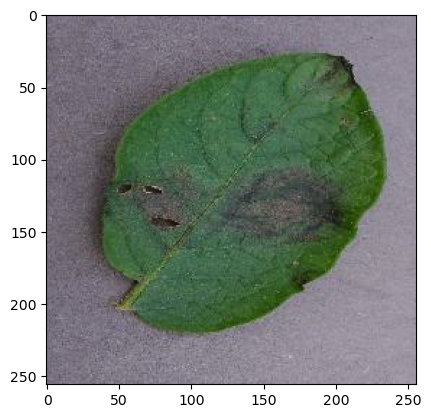

In [14]:
#各バッチでいくつ画像があるか
for batch_images, labels in dataset.take(1):#バッチにループ
    print(len(batch_images[0]))#画像の数
    
plt.imshow(batch_images[0].numpy().astype('uint8'))

# 学習・検証・テストデータに分けるモジュール作成

In [18]:
ds_size= len(dataset)
train_size= 0.8 #学習データのサイズ 
val_size= 0.2 #検証用

N_train_size= int(ds_size*train_size)#学習用のバッチ数
N_val_size= int(ds_size*val_size)#検証用のバッチ数

train_dataset= dataset.take(N_train_size)#takeは list[:N_train_size]　と同じ
val_dataset= dataset.skip(N_val_size)#ist[N_train_size : N_train_size+N_val_size]　と同じ
test_dataset= dataset.skip(N_train_size+N_val_size)# list[N_train_size+N_val_size: ]　と同じ

print(len(train_dataset),len(val_dataset),len(test_dataset))

54 55 1


# 畳み込みニューラルネットワークの構築

https://towardsdatascience.com/no-kernels-filters-are-not-the-same-b230ec192ac9

In [28]:
def get_model():
    input_layer= tf.keras.Input(shape=(256, 256, 3)) #インプット層

    x= tf.keras.layers.Rescaling(1 / 255)(input_layer) #スケーリング層

    x= tf.keras.layers.Conv2D(32, 3, activation='relu')(x) #畳み込み層：特徴を整理・抽出
    x= tf.keras.layers.MaxPooling2D(2)(x) #余計な情報を排除（小さい値は排除される）
    x= tf.keras.layers.Conv2D(32, 3, activation='relu')(x) #畳み込み層：特徴を整理・抽出
    x= tf.keras.layers.MaxPooling2D(2)(x) #余計な情報を排除（小さい値は排除される）
    x= tf.keras.layers.Conv2D(32, 3, activation='relu')(x) #畳み込み層：特徴を整理・抽出
    x= tf.keras.layers.MaxPooling2D(2)(x) #余計な情報を排除（小さい値は排除される）
    x= tf.keras.layers.Conv2D(32, 3, activation='relu')(x) #畳み込み層：特徴を整理・抽出
    x= tf.keras.layers.MaxPooling2D(2)(x) #余計な情報を排除（小さい値は排除される）
    x= tf.keras.layers.Conv2D(32, 3, activation='relu')(x) #畳み込み層：特徴を整理・抽出
    x= tf.keras.layers.MaxPooling2D(2)(x) #余計な情報を排除（小さい値は排除される）

    x= tf.keras.layers.Flatten()(x)#一列にする

    x= tf.keras.layers.Dense(64, activation='relu')(x)#適当に64個のニューロン用意

    output_layer= tf.keras.layers.Dense(3, activation='softmax')(x)#出力層：ミツのターゲットあり、一番大きい値が該当するラベルを示す

    model= tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [31]:
model= get_model()
#学習の準備
model.compile(
    optimizer='adam', #パラメータ調整方法
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),#モデルがエラーを測る方法
    metrics=['accuracy'] #人間にエラーを見せる
    )

In [32]:
history= model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset
    )

Epoch 1/20
54/54 [==============================] - 23s 420ms/step - loss: 0.8827 - accuracy: 0.5480 - val_loss: 0.6849 - val_accuracy: 0.7644
Epoch 2/20
54/54 [==============================] - 23s 425ms/step - loss: 0.5451 - accuracy: 0.8003 - val_loss: 0.3975 - val_accuracy: 0.8543
Epoch 3/20
54/54 [==============================] - 22s 413ms/step - loss: 0.3505 - accuracy: 0.8582 - val_loss: 0.4346 - val_accuracy: 0.8128
Epoch 4/20
54/54 [==============================] - 23s 423ms/step - loss: 0.2699 - accuracy: 0.8987 - val_loss: 0.1971 - val_accuracy: 0.9320
Epoch 5/20
54/54 [==============================] - 24s 436ms/step - loss: 0.2012 - accuracy: 0.9248 - val_loss: 0.1534 - val_accuracy: 0.9441
Epoch 6/20
54/54 [==============================] - 23s 434ms/step - loss: 0.1511 - accuracy: 0.9427 - val_loss: 0.1049 - val_accuracy: 0.9631
Epoch 7/20
54/54 [==============================] - 23s 430ms/step - loss: 0.1364 - accuracy: 0.9485 - val_loss: 0.2531 - val_accuracy: 0.8986

# 予測のチェック

tf.Tensor([[1.000000e+00 2.611498e-09 2.427240e-19]], shape=(1, 3), dtype=float32)
0
予測された状態: Potato___Early_blight
正しい状態: Potato___Early_blight


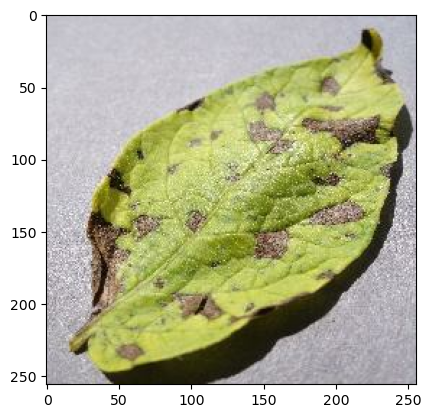

In [42]:
n_classes= dataset.class_names


for images_batch, label_batch in test_dataset.take(1):
    image= images_batch[0].numpy()
    label= label_batch[0].numpy()
    
    prediction= model(np.array([image]))
    
    print(prediction)
    print(np.argmax(prediction))
    
    print('予測された状態:',n_classes[np.argmax(prediction)])
    print('正しい状態:', n_classes[label])
    plt.imshow(image.astype('uint8'))

# 予測モジュールの作成

In [60]:
def predict(model, image, n_classes):
    prediction = model(np.array([image])) #[0.4, 0.5, 0.9]
    predicted_class= n_classes[np.argmax(prediction)]#ex:　healthy
    confidence= 100 * np.max(prediction)
    return predicted_class, confidence

('Potato___Early_blight', 99.64529275894165)


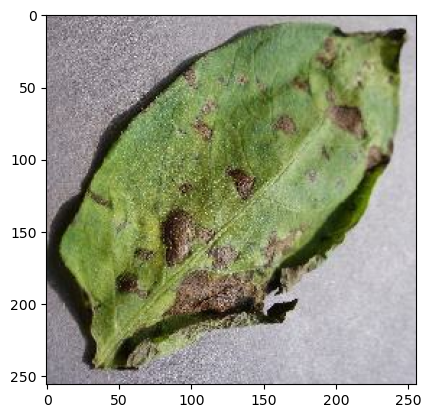

In [61]:
n_classes= dataset.class_names
for images_batch, label_batch in test_dataset.take(1):
    image= images_batch[0].numpy()
    label= label_batch[0].numpy()
    
    print(predict(model, image, n_classes))
    plt.imshow(image.astype('uint8'))
    

# モデルの保存

In [48]:
model.save('save_model_1')

INFO:tensorflow:Assets written to: save_model_1/assets


INFO:tensorflow:Assets written to: save_model_1/assets


In [50]:
loaded_model_1= tf.keras.models.load_model('save_model_1') 

# パラメータのみを保存する方法

In [52]:
model.save_weights('weight/model_weight')

In [53]:
#学習前の初期状態のモデル
model_2 = get_model()
model_2.load_weights('weight/model_weight')